In [1]:
import math
import numpy as np
from scipy import stats
import powerlaw
from fbm import FBM
import matplotlib.pyplot as plt

In [2]:
# Following the original papers, our simulations of the MF model can be described as follows. 

# Before the evolution of prices, we generate an array of relative prices {x(t):t=1, 2, · · · , T}, drawn from the Student 
# distribution with αx =1.3 and σx =0.0024, and an array of signs {s(t): t = 1, 2, · · · , T} according to a fractional 
# Brownian motion with Hs = 0.75. 

# At each simulation step t, an order is generated, whose relative price and direction are x(t) and s(t), respectively. 
# If x(t) is not less than the spread, the order is an effective market order, resulting in an immediate execution with 
# a limit order waiting at the opposite best price. 

# Otherwise, the incoming order is an effective limit order, which is stored in the queue of the limit order book. 
# Then we scan the standing orders to check if any of them can be canceled, following exactly the same process in the MF model. 

In [3]:
# Relative prices
def generate_rel_prices(alpha_x, sigma_x, T):
    relative_prices = stats.t.rvs(df=alpha_x, loc=0, scale=sigma_x, size=T, random_state=None)
    return relative_prices

In [4]:
# Signs following a fractional Brownian Motion
def generate_signs(Hs, T):
    f = FBM(n=T, hurst=Hs)

    # Generate a fgn realization
    fgn_sample = f.fgn()
    
    signs = []
    for i in range(len(fgn_sample)):
        if fgn_sample[i] >= 0:
            signs.append(1)
        else:
            signs.append(-1)
    
    return signs

In [5]:
def Mike_and_Farmer(T, Hs, A, B, alpha_x, sigma_x, ask_limit_orders, bid_limit_orders):
    signs = generate_signs(Hs, T)
    relative_prices = generate_rel_prices(alpha_x, sigma_x, T)
    
    log_prices = []
    log_returns = []
    spreads = []
    
    time_entry_ask = len(ask_limit_orders)*[0]
    time_entry_bid = len(bid_limit_orders)*[0]
    lifetime = []
    
    delta_0_ask = []
    delta_0_bid = []
    best_ask = ask_limit_orders[0]
    best_bid = bid_limit_orders[-1]
    for ask in ask_limit_orders:
        delta_0_ask.append(ask - best_bid)
    for bid in bid_limit_orders:
        delta_0_bid.append(best_ask - bid)
    
    for order in range(T):
        relative_price_i = relative_prices[order]
        sign_i = signs[order]
        
        best_ask = ask_limit_orders[0]
        best_bid = bid_limit_orders[-1]
        
        pi_mtt = 0.5*(best_ask+best_bid)
        spread = best_ask - best_bid
        
        if relative_price_i < spread: # Limit order
            if sign_i >= 0: #Buy
                log_price_i = relative_price_i + best_bid
                delta_0 = best_ask-log_price_i
                delta_0_bid.append(best_ask-log_price_i)
                bid_limit_orders.append(log_price_i)
                time_entry_bid.append(order)
                time_entry_bid = [x for _,x in sorted(zip(bid_limit_orders,time_entry_bid))]
                delta_0_bid = [x for _,x in sorted(zip(bid_limit_orders,delta_0_bid))]
                bid_limit_orders.sort()
                
            else : #Ask
                log_price_i = best_ask - relative_price_i
                delta_0 = log_price_i-best_bid
                delta_0_ask.append(log_price_i-best_bid)
                ask_limit_orders.append(log_price_i)
                time_entry_ask.append(order)
                time_entry_ask = [x for _,x in sorted(zip(ask_limit_orders,time_entry_ask))]
                delta_0_ask = [x for _,x in sorted(zip(ask_limit_orders,delta_0_ask))]
                ask_limit_orders.sort()
        
        else : # Market order
            if sign_i >= 0 and len(ask_limit_orders)>2: #Buy
                lifetime.append(order-time_entry_ask.pop(0))
                price = ask_limit_orders.pop(0)
                delta_0_ask.pop(0)
                log_prices.append(price)
            elif sign_i < 0 and len(bid_limit_orders)>2: #Ask
                lifetime.append(order-time_entry_bid.pop())
                price = bid_limit_orders.pop()
                delta_0_bid.pop()
                log_prices.append(price)
        
        # Cancelling orders !!
        N_a = len(ask_limit_orders)
        N_b = len(bid_limit_orders)
        N_t = N_a + N_b
        N_imb_a = N_a/N_t
        N_imb_b = N_b/N_t
        best_ask = ask_limit_orders[0]
        best_bid = bid_limit_orders[-1]
        
        i = 0
        while i < len(ask_limit_orders) and len(ask_limit_orders)>2:
            ask = ask_limit_orders[i]
            delta_t = ask - best_bid
            delta_0 = delta_0_ask[i]
            y_t = delta_t/delta_0
            p_c = A*(1-math.exp(-y_t))*(N_imb_a+B)/N_t
                
            u = np.random.uniform(0,1)
            if u <= p_c:
                lifetime.append(order-time_entry_ask.pop(i))
                ask_limit_orders.pop(i)
                delta_0_ask.pop(i)
            else:
                i += 1
        
        j = 0
        while j < len(bid_limit_orders) and len(bid_limit_orders)>2:
            bid = bid_limit_orders[j]
            delta_t = best_ask - bid
            delta_0 = delta_0_bid[j]
            
            y_t = delta_t/delta_0
            p_c = A*(1-math.exp(-y_t))*(N_imb_b+B)/N_t
            
            u = np.random.uniform(0,1)
            if u <= p_c:
                lifetime.append(order-time_entry_bid.pop(j))
                bid_limit_orders.pop(j)
                delta_0_bid.pop(j)
            else:
                j += 1
        
        best_ask = ask_limit_orders[0]
        best_bid = bid_limit_orders[-1]
        pi_mt = 0.5*(best_ask+best_bid)
        
        log_returns.append(abs(pi_mt-pi_mtt))
        spreads.append(best_ask-best_bid)
    
    return log_prices, log_returns, spreads, lifetime

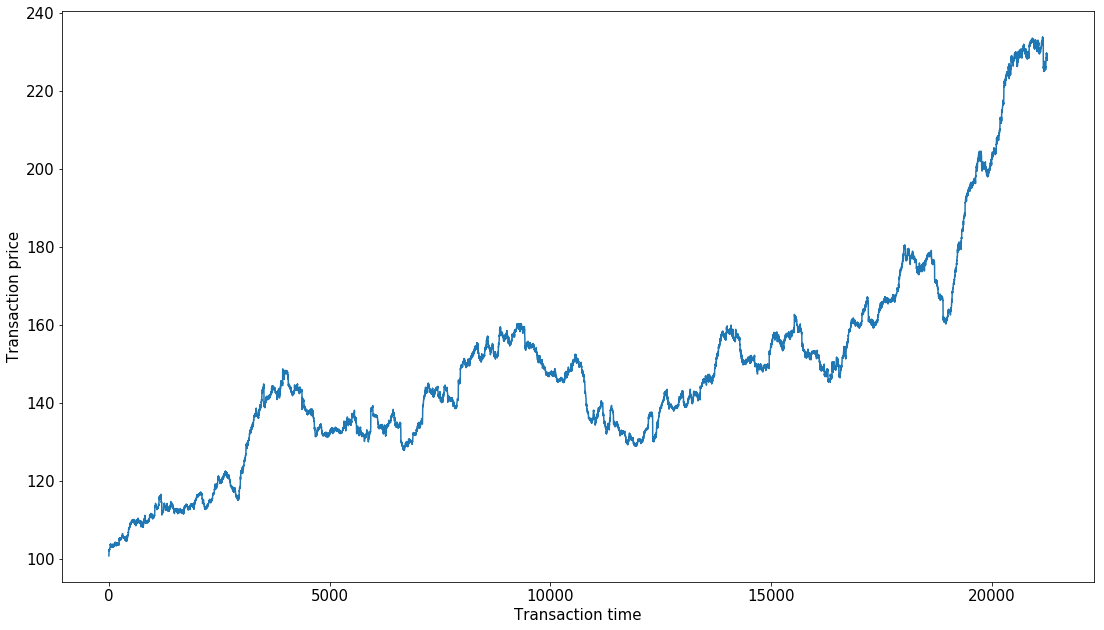

In [6]:
# Defining hyperparameters
T = 100000
alpha_x = 1.3
sigma_x = 0.0024
Hs = 0.75
A = 1.12
B = 0.2
ask_lo = np.log(np.linspace(101,110,20)).tolist()
bid_lo = np.log(np.linspace(90,99,20)).tolist()

# Simulating the model
log_prices, log_returns, spreads, lifetime = Mike_and_Farmer(T, Hs, A, B, alpha_x, sigma_x, ask_lo, bid_lo)

# Plotting the prices of transactions
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.rcParams['font.size'] = 15
plt.plot(range(len(log_prices)), np.exp(np.array(log_prices)))
plt.xlabel("Transaction time")
plt.ylabel("Transaction price")
plt.show()

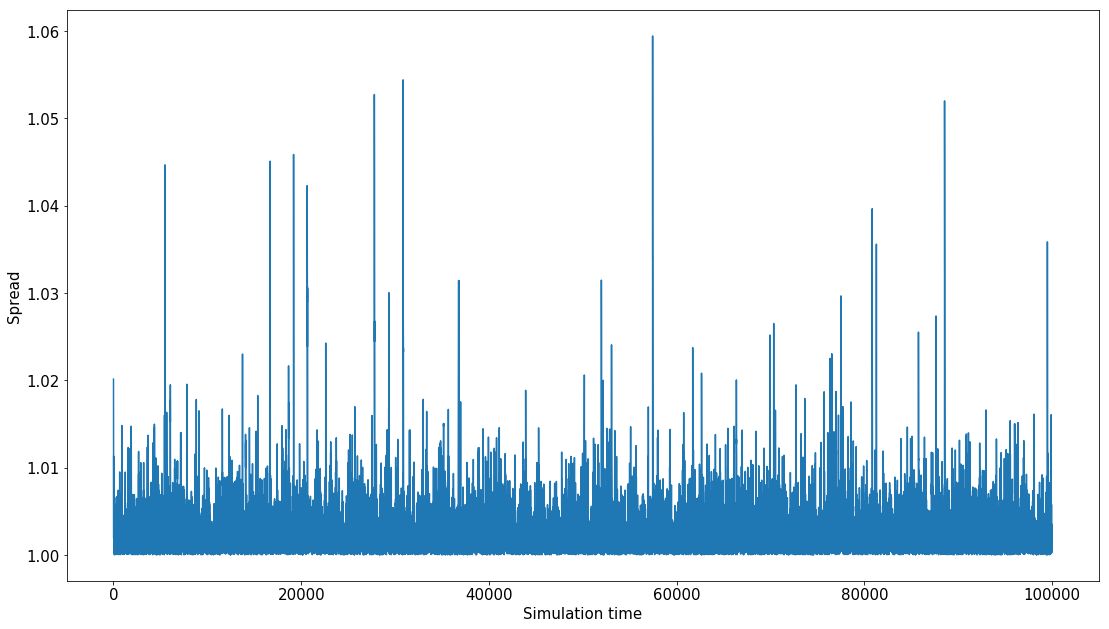

In [7]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(range(len(spreads)), np.exp(np.array(spreads)))
plt.ylabel("Spread")
plt.xlabel('Simulation time')
plt.show()

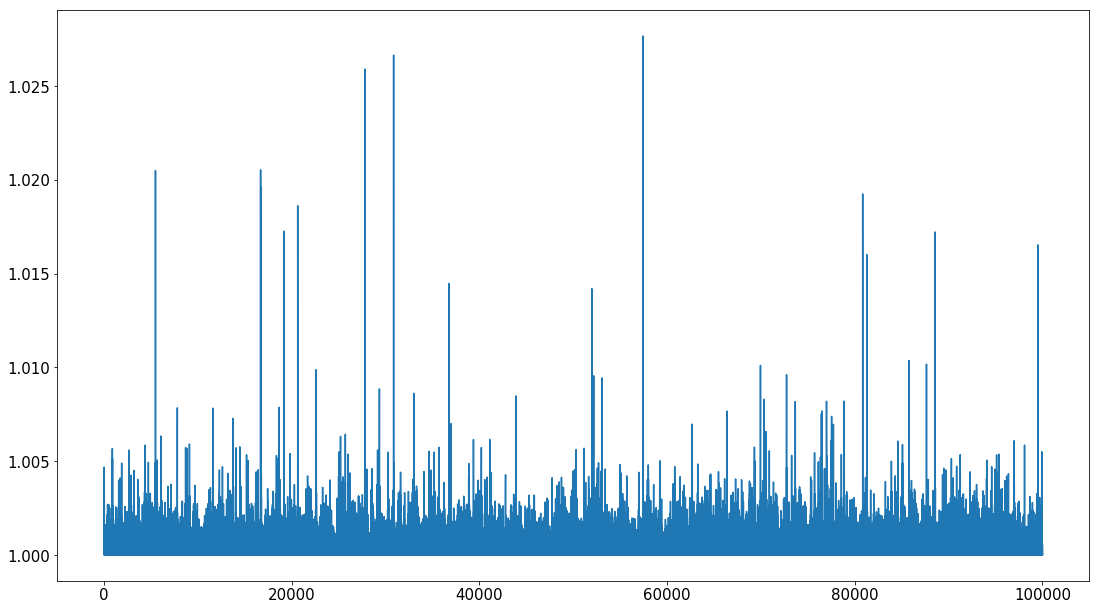

In [8]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(range(len(log_returns)), np.exp(np.array(log_returns)))
plt.show()

In [9]:
def increments(delta):
    increments = []
    i=0
    while i+delta<len(log_prices):
        diff = math.exp(log_prices[i+delta])-math.exp(log_prices[i])
        increments.append(diff)
        i += 1
    return increments

In [10]:
def log_increments(delta):
    increments = []
    i=0
    while i+delta<len(log_prices):
        diff = log_prices[i+delta]-log_prices[i]
        increments.append(diff)
        i += 1
    return increments

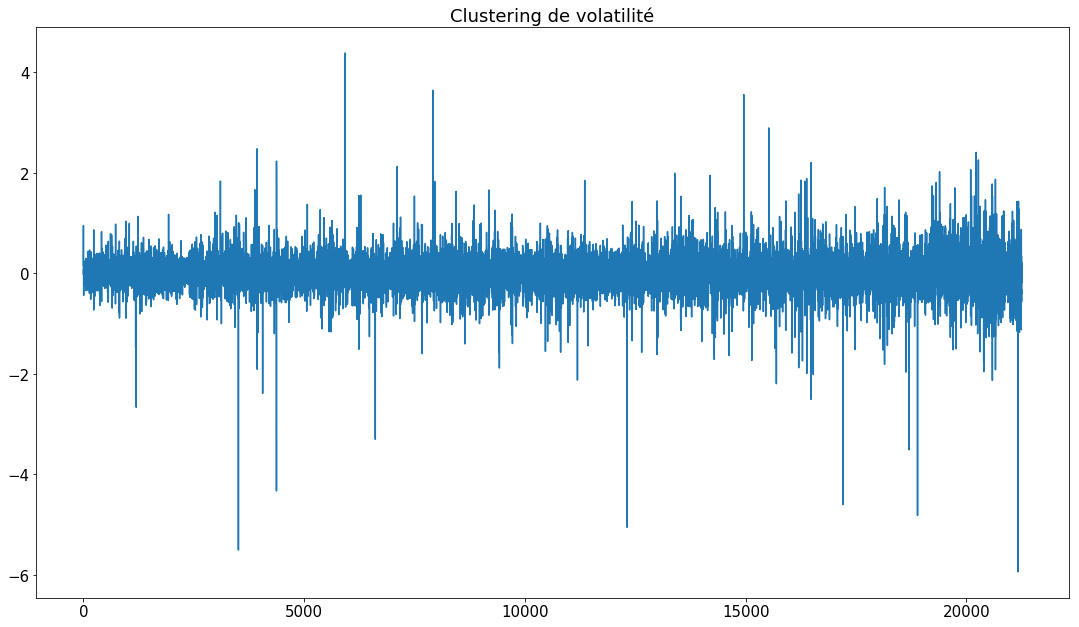

In [11]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()

#sns.distplot(incr, bins=500, hist=True)
incr = increments(1)
plt.plot(range(len(incr)), incr)
plt.title("Clustering de volatilité")
plt.show()

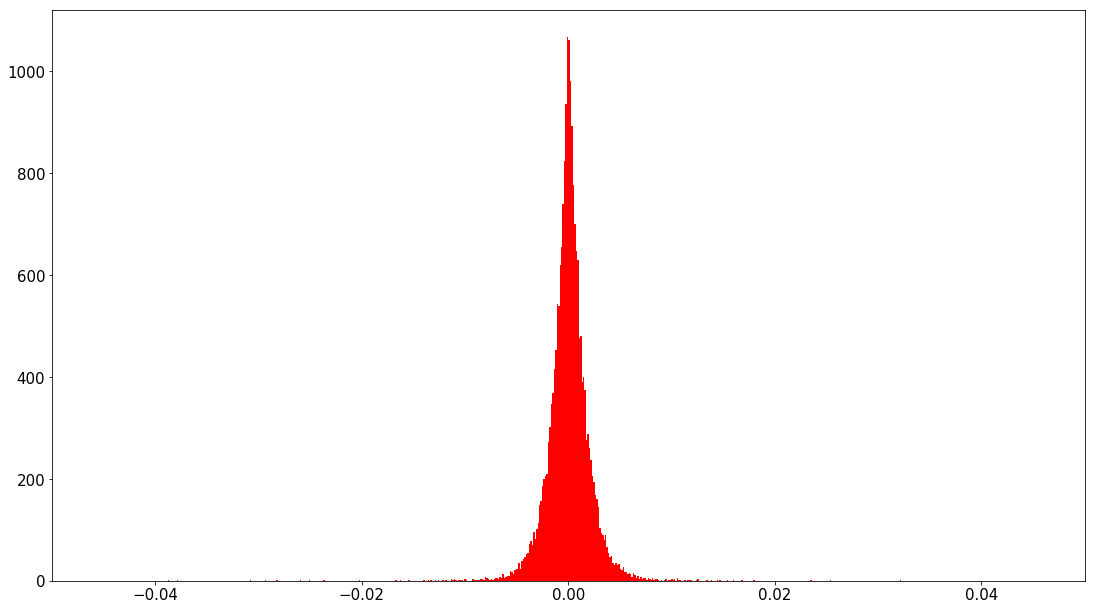

In [19]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()
ax.set_xlim(-0.05,0.05)

plt.hist(log_increments(1), bins=500, color='r')
#plt.hist(log_increments(10), bins=500, color='b')
#plt.hist(log_increments(100), bins=500, color='g')
plt.show()

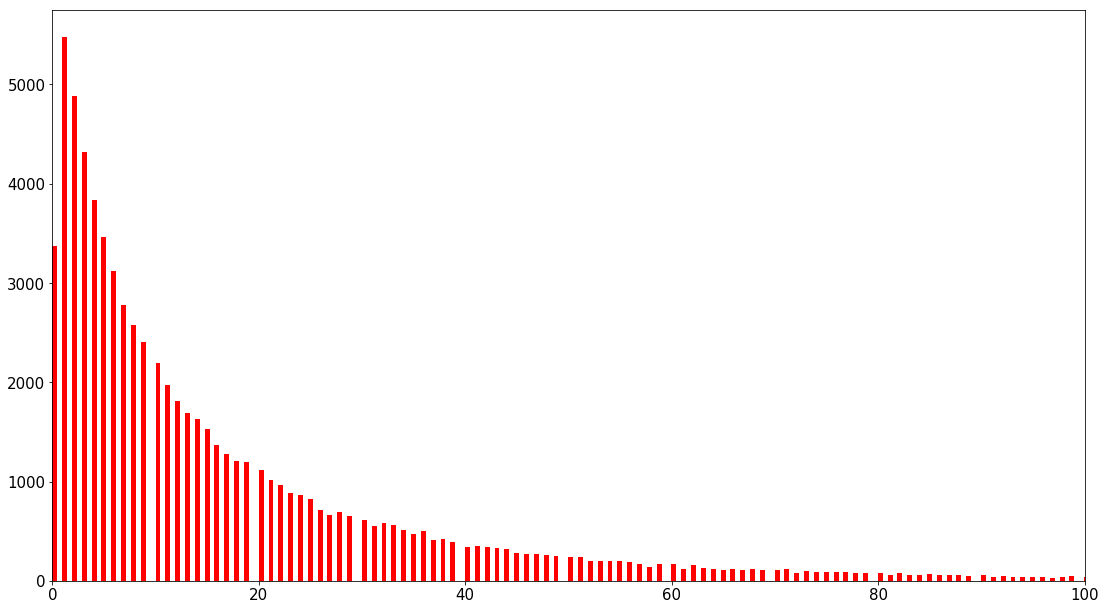

In [13]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()
ax.set_xlim(0,100)

plt.hist(lifetime, bins=1000, color='r')
#plt.hist(log_increments(10), bins=500, color='b')
#plt.hist(log_increments(100), bins=500, color='g')
plt.show()

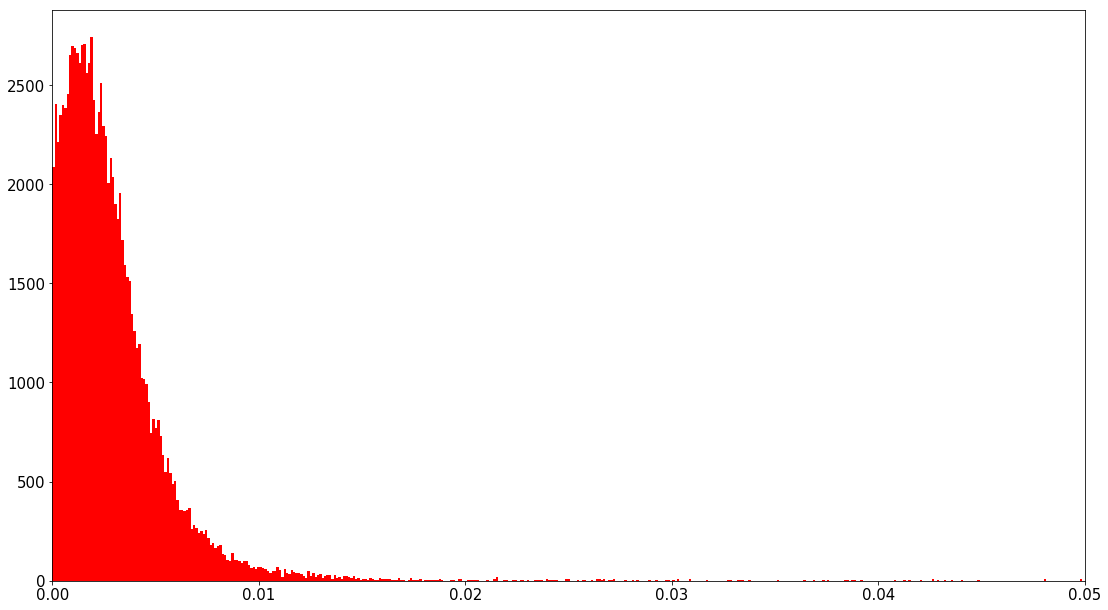

In [14]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()
ax.set_xlim(0,0.05)

plt.hist(spreads, bins=500, color='r')
#plt.hist(log_increments(10), bins=500, color='b')
#plt.hist(log_increments(100), bins=500, color='g')
plt.show()

In [15]:
def divide(mylist):
    incrP = []
    incrN = []

    for l in mylist:
        if l>0:
            incrP.append(l)
        elif l<0:
            incrN.append(-l)
            
    return incrP, incrN

In [16]:
# Calculating exponent for heavy tails

results = powerlaw.Fit(spreads)
print(results.power_law.alpha)
print(results.power_law.xmin)
#R, p = results.distribution_compare('power_law', 'lognormal')

Calculating best minimal value for power law fit
C:\Users\ElAamrani\Anaconda3\envs\tensorflow\lib\site-packages\powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


KeyboardInterrupt: 

In [ ]:
# Calculating exponent for heavy tails

results = powerlaw.Fit(log_returns)
print(results.power_law.alpha)
print(results.power_law.xmin)
#R, p = results.distribution_compare('power_law', 'lognormal')

In [ ]:
# Hurst exponent 

from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

# Assuming you have run the above code to obtain 'goog'!
print("Hurst(M&F):  %s" %(hurst(log_prices)))

In [ ]:
# AVE Model
T = 100000
Hs = 0.88
alpha_x = 1
sigma_x = 2.7*10**(-3)
A = 1.11
B = 0.22
ask_lo = np.log(np.linspace(101,110,30)).tolist()
bid_lo = np.log(np.linspace(90,99,30)).tolist()

p, r, s = Mike_and_Farmer(T, Hs, A, B, alpha_x, sigma_x, ask_lo, bid_lo)
log_returns = r
spreads = s

E_r = np.mean(log_returns)
sigma_r = np.std(log_returns)
E_s = np.mean(spreads)
sigma_s = np.std(spreads)

print("mean of returns", round(E_r*10**4,2))
print("mean of spreads", round(E_s*10**4,2))
print("standard deviation of returns", round(sigma_r*10**4,2))
print("standard deviation of spreads", round(sigma_s*10**4,2))
#results = powerlaw.Fit(log_returns)
#print("exponent of the power law of returns", results.power_law.alpha)
#results2 = powerlaw.Fit(spreads)
#print("exponent of the power law of spreads", results2.power_law.alpha)

In [ ]:
# AVE Model
T = 100000
Hs = 0.81
alpha_x = 1.25
sigma_x = 2.6*10**(-3)
A = 0.89
B = 0.22
ask_lo = np.log(np.linspace(101,110,10)).tolist()
bid_lo = np.log(np.linspace(90,99,10)).tolist()

p, r, s = Mike_and_Farmer(T, Hs, A, B, alpha_x, sigma_x, ask_lo, bid_lo)
log_returns = r[(T-40000):]
spreads = s[(T-40000):]

E_r = np.mean(log_returns)
sigma_r = np.std(log_returns)
E_s = np.mean(spreads)
sigma_s = np.std(spreads)

print("mean of returns", round(E_r*10**4,2))
print("mean of spreads", round(E_s*10**4,2))
print("standard deviation of returns", round(sigma_r*10**4,2))
print("standard deviation of spreads", round(sigma_s*10**4,2))

In [ ]:
#results = powerlaw.Fit(log_returns)
#print(results.power_law.alpha)
#print(results.power_law.xmin)

In [ ]:
#results2 = powerlaw.Fit(spreads)
#print(results2.power_law.alpha)
#print(results2.power_law.xmin)